# SSY340 Project - Trajectory Estimation LSTM

### Fill in group number and member names:

In [1]:
NAME1 = "Bingcheng Chen" 
NAME2 = "Arvin Rokni"
GROUP = "Project groups 64"

## 1. Loading the data

In [2]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import os
import dataloader
import model_LSTM
import utils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

## 2. Pre-processing

In [3]:
# defining model save location
save_location = "./LSTM_models"
# defining dataset locations
dataset_folder = "./trajectory-prediction-transformers/datasets"
dataset_name = "raw"
# setting validation size. if val_size = 0, split percentage is 80-20
val_size = 0
# length of sequence given to encoder
gt = 8
# length of sequence given to decoder
horizon = 12


train_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                             gt, horizon, delim="\t", train=True)
val_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size,
                                           gt, horizon, delim="\t", train=False)
# test_dataset, _ = dataloader.create_dataset(dataset_folder, dataset_name, val_size, \
#     gt, horizon, delim="\t", train=False, eval=True)

In [4]:
val_dataset[10]

{'src': tensor([[ 4.9693e+00,  8.3395e+00,  0.0000e+00,  0.0000e+00],
         [ 5.1330e+00,  8.3350e+00,  1.6374e-01, -4.5338e-03],
         [ 5.2968e+00,  8.3307e+00,  1.6374e-01, -4.2963e-03],
         [ 5.3915e+00,  8.3490e+00,  9.4709e-02,  1.8377e-02],
         [ 5.4565e+00,  8.3774e+00,  6.5034e-02,  2.8400e-02],
         [ 5.5218e+00,  8.4058e+00,  6.5244e-02,  2.8400e-02],
         [ 5.5868e+00,  8.4342e+00,  6.5033e-02,  2.8400e-02],
         [ 5.5988e+00,  8.4497e+00,  1.1997e-02,  1.5512e-02]]),
 'trg': tensor([[ 5.5575e+00,  8.4521e+00, -4.1251e-02,  2.3870e-03],
         [ 5.5163e+00,  8.4548e+00, -4.1251e-02,  2.6255e-03],
         [ 5.4750e+00,  8.4571e+00, -4.1251e-02,  2.3861e-03],
         [ 5.4340e+00,  8.4595e+00, -4.1041e-02,  2.3870e-03],
         [ 5.3927e+00,  8.4622e+00, -4.1251e-02,  2.6245e-03],
         [ 5.3515e+00,  8.4645e+00, -4.1251e-02,  2.3870e-03],
         [ 5.3102e+00,  8.4669e+00, -4.1251e-02,  2.3861e-03],
         [ 5.2690e+00,  8.4696e+00, -4.

In [5]:
val_dataset[10]['src'].shape

torch.Size([8, 4])

## 3. Data loaders

In [6]:
# defining batch size
batch_size = 64

# creating torch dataloaders
train_loader = DataLoader(train_dataset, batch_size,
                          shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=0)

## 4. Training

#### 4.1 create a model

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LSTM_model = model_LSTM.LSTM(input_size=2, input_seq_len=8,
                             hidden_size=128, num_layers=2, output_size=2, output_seq_len=12)

In [8]:
LSTM_model

LSTM(
  (LSTM_first_layer): ModuleList(
    (0): LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (LSTM_whole): ModuleList(
    (0): LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=2, out_features=512, bias=True)
    )
    (1): LSTMCell(
      (W_hh): Linear(in_features=128, out_features=512, bias=True)
      (W_xh): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (fc): Linear(in_features=1024, out_features=24, bias=True)
)

#### 4.2 The training loop

In [9]:
# number of epochs
epochs = 10

# metric variables
training_loss = []
validation_loss = []
val_mad = []
val_fad = []

# Define the MSE loss function
criterion = nn.MSELoss()

learning_rate = 0.001
optimizer = torch.optim.SGD(LSTM_model.parameters(), lr=learning_rate)

for epoch in tqdm(range(epochs)):
    # TRAINING MODE
    LSTM_model.train()

    # training batch variables
    train_batch_loss = 0

    for idx, data in enumerate(train_loader):
        # getting encoder input data
        X = data['src'][:, :, 0:2].to(device)
        target = data['trg'][:, :, 0:2].to(device)

        # forward pass
        optimizer.zero_grad()
        # predictions = tf_model.forward(enc_input, dec_input, dec_source_mask, dec_target_mask)
        predictions = LSTM_model.forward(X)

        loss = criterion(predictions.view(X.size(0), -1),
                         target.contiguous().view(X.size(0), -1))
        train_batch_loss += loss.item()

        # updating weights
        loss.backward()
        optimizer.step()

    training_loss.append(train_batch_loss/len(train_loader))
    print("Epoch {}/{}....Training loss = {:.4f}".format(epoch +
                                                         1, epochs, training_loss[-1]))

    # validation loop
    if (epoch+1) % 1 == 0:
        with torch.no_grad():
            # EVALUATION MODE
            LSTM_model.eval()

            # validation variables
            batch_val_loss = 0
            gt = []
            pr = []

            for id_b, data in enumerate(val_loader):
                # storing groung truth
                truth = data['trg'][:, :, 0:2]
                gt.append(data['trg'][:, :, 0:2])
                # input to encoder input
                val_input = data['src'][:, :, 0:2]
                # prediction till horizon lenght
                model_output = LSTM_model.forward(val_input)
                pr.append(model_output.view(val_input.size(0), 12, -1))

                # calculating loss using pairwise distance of all predictions
                val_loss = criterion(model_output.view(val_input.size(
                    0), -1), truth.contiguous().view(val_input.size(0), -1))
                batch_val_loss += val_loss.item()

            validation_loss.append(batch_val_loss/len(val_loader))

            # calculating mad and fad evaluation metrics
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            mad, fad, _ = dataloader.distance_metrics(gt, pr)
            val_mad.append(mad)
            val_fad.append(fad)

            print("Epoch {}/{}....Validation mad = {:.4f}, Validation fad = {:.4f}".format(
                epoch+1, epochs, mad, fad))

    # Saving model, loss and error log files
    torch.save({
        'model_state_dict': LSTM_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_loss': training_loss,
        'validation_loss': validation_loss,
        'val_mad': val_mad,
        'val_fad': val_fad,
        'learning_rate': learning_rate
    }, os.path.join(save_location, 'LSTM_epoch{}.pth'.format(epoch+1)))


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10....Training loss = 24.2468


 10%|█         | 1/10 [00:04<00:43,  4.78s/it]

Epoch 1/10....Validation mad = 3.6281, Validation fad = 4.3869
Epoch 2/10....Training loss = 8.0391


 20%|██        | 2/10 [00:09<00:36,  4.54s/it]

Epoch 2/10....Validation mad = 3.4509, Validation fad = 4.2711
Epoch 3/10....Training loss = 7.4663


 30%|███       | 3/10 [00:13<00:31,  4.51s/it]

Epoch 3/10....Validation mad = 3.3120, Validation fad = 4.1959
Epoch 4/10....Training loss = 6.3589


 40%|████      | 4/10 [00:18<00:27,  4.52s/it]

Epoch 4/10....Validation mad = 2.8367, Validation fad = 3.9000
Epoch 5/10....Training loss = 4.9508


 50%|█████     | 5/10 [00:22<00:22,  4.47s/it]

Epoch 5/10....Validation mad = 2.5405, Validation fad = 3.6665
Epoch 6/10....Training loss = 4.3767


 60%|██████    | 6/10 [00:27<00:18,  4.54s/it]

Epoch 6/10....Validation mad = 2.4233, Validation fad = 3.5562
Epoch 7/10....Training loss = 3.8806


 70%|███████   | 7/10 [00:31<00:13,  4.60s/it]

Epoch 7/10....Validation mad = 2.2373, Validation fad = 3.3560
Epoch 8/10....Training loss = 3.2374


 80%|████████  | 8/10 [00:36<00:09,  4.59s/it]

Epoch 8/10....Validation mad = 2.2288, Validation fad = 3.2516
Epoch 9/10....Training loss = 2.6968


 90%|█████████ | 9/10 [00:41<00:04,  4.63s/it]

Epoch 9/10....Validation mad = 2.1769, Validation fad = 3.0556
Epoch 10/10....Training loss = 2.3243


100%|██████████| 10/10 [00:45<00:00,  4.60s/it]

Epoch 10/10....Validation mad = 1.5541, Validation fad = 2.4711


## 5. Visualisation

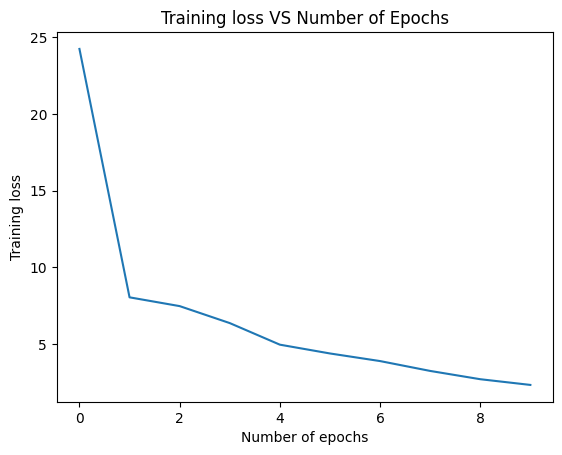

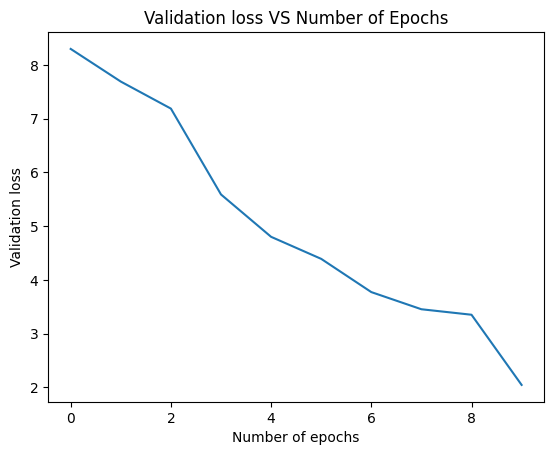

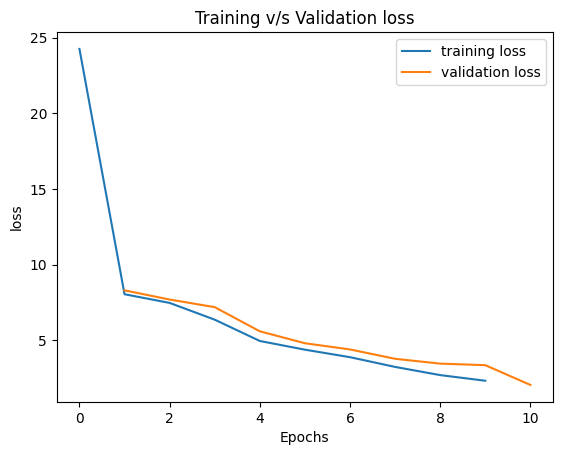

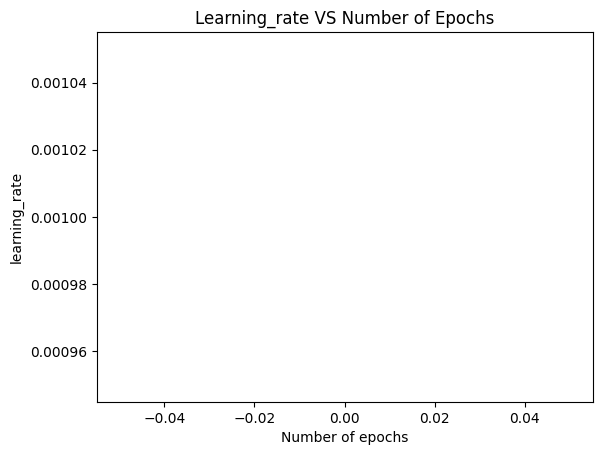

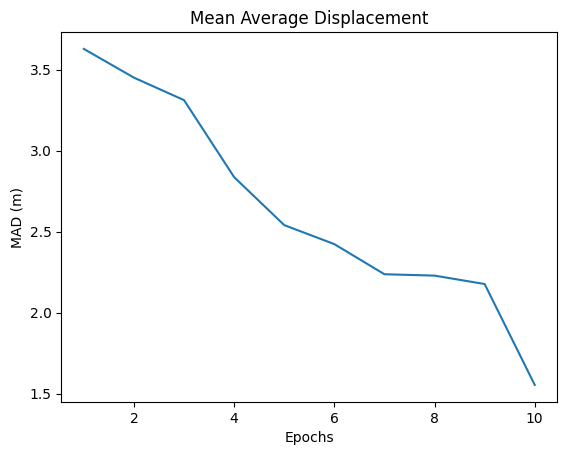

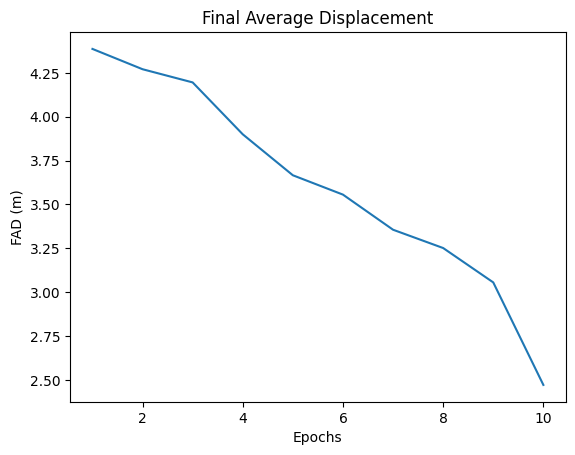

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_file = torch.load(os.path.join(
    save_location, 'LSTM_epoch10.pth'), map_location=torch.device(device))

# creating model and loading weights
# encoder_ip_size = 2
# decoder_ip_size = 3
# model_op_size = 3
# emb_size = 512
# num_heads = 8
# ff_hidden_size = 2048
# n = 6
# dropout = 0.1

# model_loaded = model.TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size,
#                              num_heads, ff_hidden_size, n, dropout=0.1)

model_loaded = model_LSTM.LSTM(input_size=2, input_seq_len=8,
                             hidden_size=128, num_layers=2, output_size=2, output_seq_len=12)


model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(loaded_file['model_state_dict'])

# loading training metric variables
training_loss = loaded_file['training_loss']
validation_loss = loaded_file['validation_loss']
val_mad = loaded_file['val_mad']
val_fad = loaded_file['val_fad']
learning_rate = loaded_file['learning_rate']

# plotting training loss
plt.figure()
plt.plot(training_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Training loss VS Number of Epochs")

# plotting validation loss
plt.figure()
plt.plot(validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss VS Number of Epochs")

# plotting training and validation loss together
plt.figure()
plt.plot(loaded_file['training_loss'], label="training loss")
plt.plot(np.arange(1, 11, 1),
            loaded_file['validation_loss'], label="validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Training v/s Validation loss")
plt.savefig("loss.png")

# plotting learning rate for model
plt.figure()
plt.plot(learning_rate)
plt.xlabel("Number of epochs")
plt.ylabel("learning_rate")
plt.title("Learning_rate VS Number of Epochs")

# plotting MAD
plt.figure()
plt.plot(np.arange(1, 11, 1),
            loaded_file['val_mad'], label="validation MAD")
plt.xlabel("Epochs")
plt.ylabel("MAD (m)")
plt.title("Mean Average Displacement")
plt.savefig("mad.png")

# plotting FAD
plt.figure()
plt.plot(np.arange(1, 11, 1),
            loaded_file['val_fad'], label="validation FAD")
plt.xlabel("Epochs")
plt.ylabel("FAD (m)")
plt.title("Final Average Displacement")
plt.savefig("fad.png")

plt.show()

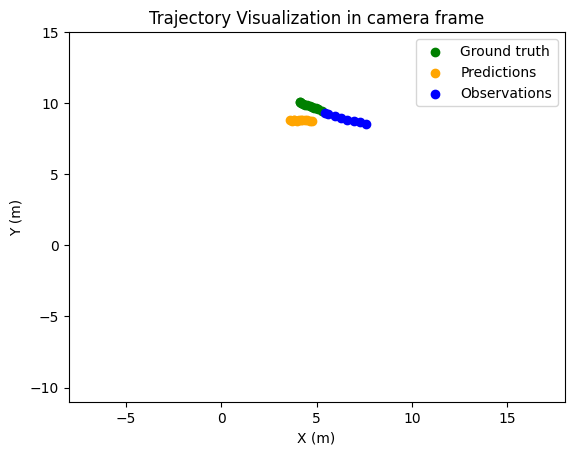

In [13]:
# Running the validation loop to generate prediction trajectories on validation data
validation_loss = []
val_mad = []
val_fad = []

with torch.no_grad():
    # EVALUATION MODE
    model_loaded.eval()

    # validation variables
    batch_val_loss = 0
    gt = []
    pr = []
    obs = []

    for id_b, data in enumerate(val_loader):
        # storing groung truth
        truth = data['trg'][:, :, 0:2]
        gt.append(data['trg'][:, :, 0:2])
        obs.append(data['src'][:, :, 0:2])
        # input to encoder input
        val_input = data['src'][:, :, 0:2]

        # prediction till horizon lenght
        model_output = model_loaded.forward(val_input)
        pr.append(model_output.view(val_input.size(0), 12, -1))

        # calculating loss using pairwise distance of all predictions
        val_loss = criterion(model_output.view(val_input.size(0), -1), truth.contiguous().view(val_input.size(0), -1))
        batch_val_loss += val_loss.item()

        validation_loss.append(batch_val_loss/len(val_loader))

    # calculating mad and fad evaluation metrics
    gt = np.concatenate(gt, 0)
    pr = np.concatenate(pr, 0)
    obs = np.concatenate(obs, 0)
    mad, fad, _ = dataloader.distance_metrics(gt, pr)
    val_mad.append(mad)
    val_fad.append(fad)

# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

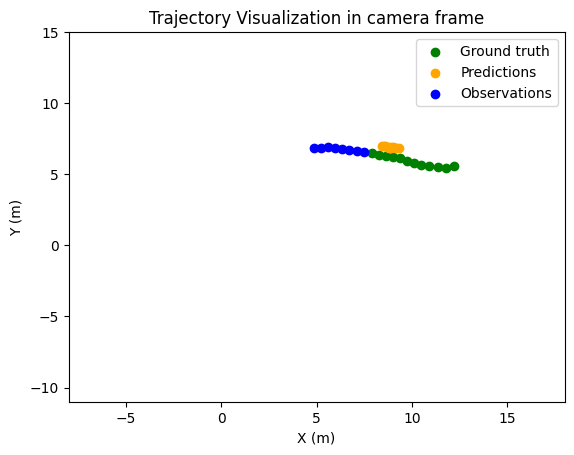

In [14]:
# plotting the predicted and ground truth trajectories
idx = np.random.randint(0, gt.shape[0])
plt.figure()
plt.scatter(gt[idx, :, 0], gt[idx, :, 1],
            color='green', label="Ground truth")
plt.scatter(pr[idx, :, 0], pr[idx, :, 1],
            color='orange', label="Predictions")
plt.scatter(obs[idx, :, 0], obs[idx, :, 1],
            color='b', label="Observations")
plt.legend()
plt.xlim(-8, 18)
plt.ylim(-11, 15)
plt.title("Trajectory Visualization in camera frame")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")
plt.savefig("traj_{}".format(idx))

plt.show()

## 6. Evaluation on test set